In [127]:
%load_ext autoreload
%autoreload 2

# standard stuff
import os
import pandas as pd
import numpy as np
np.random.seed(123)
import json
import pickle 
import time
from tqdm import tqdm
import datetime as dt
from collections import Counter
from time import time


# text processing
with open('stopwords-de_no-parties.json', 'r') as file:
    stopwords_de = json.load(file)
import spacy
nlp = spacy.load('de')


# visualization 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

# SK-LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Gensim LDA
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

# custom imports
from data_handling import load_data, collapse_dfs
from text_preprocessing import df_processing, party_remover
from lda_functions import sparse_text, party_substituter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
read_in = False
path = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/lda_data.pickle'
parties = ['AfD', 'SPD', 'CDU', 'CSU', 'FDP', 'LINKE', 'Gruene', 'Grüne']
dates = ['08-{:02d}'.format(i) for i in range(2,10)]


if read_in:
    parties = parties
    dates = dates
    aug_data = {}
    print('Loading: {}'.format(dates))
    for party in parties:
        load_list = ['../Data/{}/{}_2018-{}.json'.format(party, party, day) for day in dates]
        aug_data[party] = load_data(load_list)
        print('{} loaded'.format(party))
    with open(path, 'wb') as fid:
        pickle.dump(aug_data, fid)
    print("Done")
else:
    print('loading data from pickle')
    with open(path, 'rb') as fid:
        aug_data = pickle.load(fid)
        print('data loaded')


  0%|          | 0/8 [00:00<?, ?it/s]

Loading: ['08-02', '08-03', '08-04', '08-05', '08-06', '08-07', '08-08', '08-09']



100%|██████████| 8/8 [01:06<00:00,  8.26s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

AfD loaded



100%|██████████| 8/8 [00:20<00:00,  2.55s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

SPD loaded



100%|██████████| 8/8 [00:17<00:00,  2.21s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

CDU loaded



100%|██████████| 8/8 [00:15<00:00,  1.90s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

CSU loaded



100%|██████████| 8/8 [00:47<00:00,  5.89s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

FDP loaded



100%|██████████| 8/8 [00:13<00:00,  1.72s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

LINKE loaded



100%|██████████| 8/8 [00:09<00:00,  1.13s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

Gruene loaded



100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


Grüne loaded
Done


In [4]:
collapse = False
path_collapse = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/all_data_lda.pickle' # path where pickle file is saved

if collapse:
    all_data = collapse_dfs(aug_data)
    df_processing(all_data)
    all_data = all_data.drop_duplicates('clean_text')
    all_data['user_id'] = all_data.loc[:, 'user'].map(lambda x: x['id_str'])
    all_data.drop('user', inplace=True, axis=1)
    print('dumping data to pickle')
    with open(path_collapse, 'wb') as fid:
        pickle.dump(all_data, fid)
    print('data dumped')
else: 
    print('loading data from pickle')
    with open(path_collapse, 'rb') as fid:
        all_data = pickle.load(fid)
        print('data loaded')

loading data from pickle
data loaded


# LDA using the scikit-learn package

In [4]:
cv = CountVectorizer(stop_words=stopwords_de,
                    max_df=.1,
                    max_features=5000)

X = cv.fit_transform(all_data.loc[:, 'clean_text'])

In [5]:
lda = LatentDirichletAllocation(n_components=5,
                               random_state=123,
                               learning_method='batch')

X_topics = lda.fit_transform(X)

In [6]:
lda.components_.shape

(5, 5000)

In [7]:
n_top_words = 5
feature_names = cv.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print('Topic {}'.format(topic_idx + 1))
    print(' '.join([feature_names[i] for i in topic.argsort()[:-n_top_words -1:-1]]))

Topic 1
aufstehen partei sammlungsbewegung linken wagenknecht
Topic 2
ueber nazis partei waehler rechts
Topic 3
cdu fdp csu wehrpflicht merkel
Topic 4
gruene politik einfach leute muessen
Topic 5
gruene deutschland csu seehofer bayern


In [47]:
def daily_topifier(df, cv_features, n_topics, n_top_words):
    dates = ['2018-08-{:02d}'.format(i) for i in range(2,10)]
    topics = {}
    
    for date in dates:
        cv = CountVectorizer(stop_words=stopwords_de, max_df=.1, max_features=cv_features)
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=123, learning_method='batch')
        X = cv.fit_transform(df.loc['{}'.format(date), 'clean_text'])
        X_topics = lda.fit_transform(X)
        feature_names = cv.get_feature_names()
        for topic_idx, topic in enumerate(lda.components_):
            topics['{}, {}'.format(date, topic_idx + 1)] = [' '.join([feature_names[i] for i in topic.argsort()[:-n_top_words -1:-1]])]
            
    return topics

In [51]:
topics = daily_topifier(all_data, cv_features=5000, n_topics=5, n_top_words=5)

topics
# interesting: afd is very common but does not appear to be a topic

# LDA using gensim 

- take only words with certain tags from the cleaned text (tags in this context referring to word tags = nouns, adjectives, ect.)
- prepare a common dictionary
- prepare common corpus with vectorized (bow) words
- run lda on corpus and evaluate coherence using the coherence model and visualizations

In [137]:
save = True

path_com_corpus = '../Data/lda_noplower_ccorpus.pkl'
path_corpus = '../Data/lda_noplower_corpus'
path_dic = '../Data/lda_noplower_dic.pkl'

if save:
    text = all_data.loc[:, 'clean_text'].map(lambda x: x.lower()).map(party_substituter)

    document = []

    for row in text.iteritems():
        index, data = row
        document.append(data)
    
    lengths = len(document)
    corpus = []
    tick = time()
    for i, term in enumerate(document):
        corpus.append(sparse_text(term, nlp))
        print('{}/{}'.format(i, lengths), end='\r')
        if i % 5000 == 0:
            t1 = (time() - tick)/60
            print('Took {:.2f} min for {} loops'.format(t1, i))
    print('The entire process took {:.2f} min'.format((time() - tick)/60))

    common_dictionary = corpora.Dictionary(corpus, prune_at=100000)

    common_corpus = [common_dictionary.doc2bow(row) for row in corpus]
    
    with open(path_com_corpus, 'wb') as fid:
        pickle.dump(common_corpus, fid)
    with open(path_dic, 'wb') as fid:
        pickle.dump(common_dictionary, fid)
    with open(path_corpus, 'wb') as fid:
        pickle.dump(corpus, fid)       

else:
    with open(path_com_corpus, 'rb') as fid:
        common_corpus = pickle.load(fid)
    with open(path_dic, 'rb') as fid:
        common_dictionary = pickle.load(fid)
    with open(path_corpus, 'rb') as fid:
        corpus = pickle.load(fid)

Took 0.00 min for 0 loops
Took 1.65 min for 5000 loops
Took 3.32 min for 10000 loops
Took 4.97 min for 15000 loops
Took 6.62 min for 20000 loops
Took 8.29 min for 25000 loops
Took 9.98 min for 30000 loops
Took 11.67 min for 35000 loops
Took 13.35 min for 40000 loops
Took 14.99 min for 45000 loops
Took 16.64 min for 50000 loops
Took 18.31 min for 55000 loops
Took 20.01 min for 60000 loops
Took 21.71 min for 65000 loops
Took 23.41 min for 70000 loops
Took 25.05 min for 75000 loops
Took 26.70 min for 80000 loops
Took 28.35 min for 85000 loops
Took 29.98 min for 90000 loops
Took 31.50 min for 95000 loops
Took 33.08 min for 100000 loops
Took 34.73 min for 105000 loops
Took 36.36 min for 110000 loops
Took 38.16 min for 115000 loops
The entire process took 38.46 min


In [136]:
len(common_dictionary)

11774

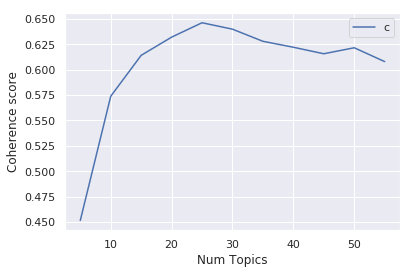

TypeError: 'str' object is not callable

In [134]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute coherence for various number of topics

    Parameters:
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Plots coherence score over number of topics
    """
    coherence_values = []
    model_list = []
    tick = time()
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, 
                       id2word=dictionary, 
                       num_topics=num_topics, 
                       alpha=0.001, 
                       minimum_probability=0.2,
                       iterations=20)                 
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    print('Process took {} min'.format((time()-tick)/60))
        
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    

compute_coherence_values(common_dictionary, common_corpus, corpus, limit=60, start=5, step=5)

Following from coherence score curve
- choose 22 topics: highest coherence score before curve flattens out 
- given the corpus 20 topics make more sense than 80 - this can also be seen in the LDA visualization: with 80 topics, most of them cluster in the lower-right corner

Following from LDA visualization
- comparing topic-bubbles of different numbers of topics: chosing 17 topics results in nicely distributed, hardly overlapping clusters

In [135]:
lda = LdaModel(common_corpus, 
               num_topics=25, 
               id2word=common_dictionary, 
               alpha=0.001, 
               random_state=123, 
               minimum_probability=0.2,
               per_word_topics=True,
               iterations=70)

# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda, texts=corpus, dictionary=common_dictionary, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score c_v: ', coherence_lda)

# Compute Coherence Score using u-mass
coherence_model_lda = CoherenceModel(model=lda, texts=corpus, dictionary=common_dictionary, coherence='u_mass')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score u-mass: ', coherence_lda)

perplexity = lda.log_perplexity(common_corpus)
print('Model perplexity: ', perplexity)

ldavis_prepared = pyLDAvis.gensim.prepare(lda, common_corpus, common_dictionary)

pyLDAvis.display(ldavis_prepared)

Coherence Score c_v:  0.619422774292866
Coherence Score u-mass:  -17.864873128888757
Model perplexity:  -10.342644890835487


/home/franzi/miniconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

- A topic in LDA is a multinomial distribution over the (typically thousands of) terms in the vocabulary of the corpus. 

In [331]:
lda.top_topics(corpus=common_corpus)

[([(0.11611071, 'Klimawandel'),
   (0.037510283, 'Sammelbewegung'),
   (0.035783961, 'Ideologie'),
   (0.03160321, 'Demokratie'),
   (0.022615083, 'Werte'),
   (0.022137519, 'soziale'),
   (0.021200893, 'Blick'),
   (0.018040378, 'Kosten'),
   (0.016673179, 'Positionen'),
   (0.015409702, 'Hilfe'),
   (0.015051554, 'Schule'),
   (0.012794786, 'Energiewende'),
   (0.012649757, 'Auslaender'),
   (0.011805871, 'Spektrum'),
   (0.011561305, 'Steuerzahler'),
   (0.011505001, 'Neues'),
   (0.0095258597, 'Partei'),
   (0.0090149641, 'Verbrecher'),
   (0.0087966118, 'Gerechtigkeit'),
   (0.008548215, 'absolute')],
  -12.970464622973111),
 ([(0.071270771, 'Fluechtlinge'),
   (0.040500119, 'Deutschen'),
   (0.040139761, 'Bundestag'),
   (0.035875183, 'Themen'),
   (0.035226185, 'Debatte'),
   (0.033502724, 'Migranten'),
   (0.032914698, 'Sommer'),
   (0.027701339, 'Grenzen'),
   (0.021182377, 'Sachen'),
   (0.019982252, 'Loesung'),
   (0.015615266, 'Zahlen'),
   (0.01401592, 'Vorschlag'),
   (0.

In [332]:
lda.get_topic_terms()

<bound method LdaModel.get_topic_terms of <gensim.models.ldamodel.LdaModel object at 0x7f7a57646048>>

In [18]:
def format_topics_sentences(ldamodel, corpus, texts):
    
    topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topics_df = topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = texts
    topics_df = pd.concat([topics_df, contents], axis=1)
    return(topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=common_corpus, texts=corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

TypeError: cannot concatenate object of type "<class 'list'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid